In [1]:

#import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import initializers
from keras.utils.generic_utils import get_custom_objects

import pandas as pd


from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import math

In [207]:
#solve ODEs for the error function

class feature_class:
    
    
    def __init__(self,K,M,eta,tStop,alpha,beta,sigma=0,R0=0,Q0=0,T0=0,c0=0):
        self.rnd=a
        self.tStop=tStop
        np.random.seed(None)
        self.K=K
        self.alpha=alpha
        self.beta=beta
        self.M=M
        
        self.eta=eta
        self.N=N
        self.sigma=sigma
        self.R0=R0
        self.Q0=Q0
        self.T=T0
        self.c0=c0
        np.random.seed(self.rnd)
     
    
    def I_2_st(self,i,n):
        C11=self.Q0[i][i]
        C12=self.R0[i][n]
        C21=C12
        C22=self.T[n][n]
        
        
        return 1/np.pi*np.arcsin(C12/(np.sqrt(C11+1)*np.sqrt(C22+1)))
    
    def I_2_ss(self,i,k,c):
        C11=self.Q0[i][i]
        C12=self.Q0[i][k]
        C21=C12
        C22=self.Q0[k][k]
        
        
        return 1/np.pi*c[k]*np.arcsin(C12/(np.sqrt(C11+1)*np.sqrt(C22+1)))
        
        
        
    def deriv_c(self,i,c):
        
        I_2_i_k=0
        I_2_i_n=0
        for k in range(0,self.K):
            
            I_2_i_k+=self.I_2_ss(i,k,c)
            
        for n in range(0,self.M):
            I_2_i_n+=self.I_2_st(i,n)
            
    
        a=2*self.eta*self.alpha*(self.beta*I_2_i_n-self.alpha*I_2_i_k)
        
        return a
    
    
    
    def func(self,t,y):
    
      
        c=y[:]
        
        derivs=[]

        for i in range(0,self.K):
                
                derivs.append(self.deriv_c(i,c))         
                     
        return derivs
    
    
    def sol(self):
        tStop = self.tStop
        tInc =1.
        t = np.arange(0., tStop, tInc)

        y0=self.c0
     
        
        psoln =solve_ivp(self.func,[0,tStop],y0,t_eval=t,atol=1e-12,rtol=1e-13)

        return psoln
    
    def epsilon(self):
        x=self.sol()
        c=x.y
        epsilon=[]
        
        
        for l in range(0,int(len(x.t))):  
        
            T_nm=self.T
            R_in=self.R0
            Q_ik=self.Q0
            a=0
            for i in range(0,self.K):
                for k in range(0,self.K):
                    a+=c[i,l]*c[k,l]*np.arcsin(Q_ik[i,k]/(np.sqrt(((1+Q_ik[i,i])))*np.sqrt((1+Q_ik[k,k]))))
                    
                    
            b=0
            for n in range(0,self.M):
                for m in range(0,self.M):
                    b+=np.arcsin(T_nm[n,m]/(np.sqrt(((1+T_nm[m,m])))*np.sqrt((1+T_nm[n,n]))))
                
            d=0
            for i in range(0,self.K):
                for n in range(0,self.M):
                    d+=c[i,l]*np.arcsin(R_in[i,n]/(np.sqrt(((1+Q_ik[i,i])))*np.sqrt((1+T_nm[n,n]))))
            
            epsilon.append(1/np.pi*(self.alpha**2*a+self.beta**2*b-2*self.alpha*self.beta*d))   
       
            
        return x.t,epsilon

In [299]:

#define mean-squared-error
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true- y_pred)
    return 1/2*tf.reduce_mean(squared_difference)  

#define one-pass stochastic gradient descent in the student teacher framework
def online_(student,teacher,N,p,var):
    """
In: student: tensorflow model "student"
    teacher: tensorflow model "teacher"
    
    N: input-layer size   
    p: defines the number of training data presented in once and in a sequential order
Out:  np.array(error_test): generalization error
    np.array(train): loss error
    np.array(w):weights of the student

"""
    

    np.random.seed(None)
    x_test=np.random.normal(loc=0,scale=1,size=(5000,N))
    noise_test=np.random.normal(loc=0.,scale=np.sqrt(var),size=len(x_test)).astype('float32')
    train=[]
    error_test=[]
    end=int(p/(K))
    w=[]
    
    for alpha in range(0,end):
        # use K examples at once for one step
        # this is our defined resolution alpha=p/K for the ultra-wide limit
        x_train=np.random.normal(loc=0,scale=1,size=(K,N))
        
        #create test and train labels by teacher neural network
        #with noise if necessary
        noise_train=np.random.normal(loc=0,scale=np.sqrt(var),size=len(x_train)).astype('float32')
        labels=teacher(x_train)+tf.reshape(tf.convert_to_tensor(noise_train),(len(x_train),1))
        
        labels_test=teacher(x_test)+tf.reshape(tf.convert_to_tensor(noise_test),(len(x_test),1))
        error_test.append(np.mean(teacher.loss(labels_test,student(x_test))))
        
        w.append(student.weights[1].numpy()[:])
        
        # update the student
        # batch_size and epochs correspond to one-pass algorithm
        history =student.fit(
           x=x_train,
            y=labels,
            epochs = 1,
            batch_size=1,
            verbose = 0,
            use_multiprocessing=True)
      
        
        
        train.append(history.history["loss"])
        
        # print generalization error at initialization and after every 1000 steps
        if not alpha%1000:
            print(alpha)
            print(error_test[alpha])
        
    return np.array(error_test),np.array(train), np.array(w)

In [329]:
#initialize student and teacher vectors

M=1
N=100
teacher=teacher_SCM(N,M,seed=11)
K=100
np.random.seed(5)
tf.random.set_seed(5)

kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
s=[]
s.append(kernel_initializer((K,N)).numpy())
for i in range(K):
    
    s[0][i]=s[0][i]/np.linalg.norm(s[0][i])*np.sqrt(N)

kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
t=[]
t.append(kernel_initializer((M,N)).numpy())
for j in range(M):

    t[0][j]=t[0][j]/np.linalg.norm(t[0][j])*np.sqrt(N)


s=np.array(s).reshape(K,N)
t=np.array(t).reshape(M,N)



In [330]:
#set new teacher weights

new_weights=np.zeros((N,M))
    
for i in range(0,M):
            
    new_weights[:,i]=t[i]


b=[]
    
b.append(new_weights)
b.append(teacher.weights[1].numpy())

    
teacher.set_weights(b)

In [331]:
#set seed for hidden-to-output initial weights

np.random.seed(123)
c0=np.random.normal(0.,1/np.sqrt(K),size=K)

In [333]:
#Train the student
#this is the simulation part

end=1000
p=end*K
multi_errK100=[]
R=[]
l1=np.array([K])

c_training=[]
for i in range(1):
    R2=[]
    error=[]
    for K in l1:
        student=student_out(N,K,M,eta=0.1/K,seed=10+5*i)
        new_weights=np.zeros((N,K))
    
        for i in range(0,K):
            
    
            new_weights[:,i]=s[i]


        b=[]
    
        b.append(new_weights)
        b.append(c0.reshape(K,1))

    
        student.set_weights(b)

    
        
        e=[]
         
       
    

        
    
        f=online_gamma(student,teacher,N,p,K,0.0)
        h=f[0]
        c_training.append(f[2])
        e.append(f[1])
        error.append(h)
        print(K)
   
        
    multi_errK100.append(np.array(error))
    

0
0.38874796
100
0.04379494
200
0.03686429
300
0.034214493
400
0.033649918
500
0.03318912
600
0.032953016
700
0.03265192
800
0.03261372
900
0.03245871
100


In [334]:
tStop = end
tInc =1
ti2 = np.arange(0., tStop, tInc)

# Solution of ODEs

In [336]:
#use same initial student teacher weights as for the simulation

Q=[]
for i in range(K):
    for j in range(K):
        
        Q.append(np.matmul(s[i],s[j])/N)
Q=np.array(Q).reshape(K,K)

R=[]
for i in range(K):
    for n in range(M):
        
        R.append(np.matmul(s[i],t[n])/N)
R=np.array(R).reshape(K,M)


T=[]
for i in range(M):
    for n in range(M):
        
        T.append(np.matmul(t[n],t[n])/N)
T=np.array(T).reshape(M,M)




In [337]:

#run code for solutions of the ODEs
#use same initial values as for the simulation part
error100=[]

    
a2=feature_class(K=K,M=1,eta=0.1,alpha=1,beta=1,tStop=1000,R0=R.reshape(K,M),Q0=Q.reshape(K,K),T0=T.reshape(M,M),c0=c0)


error100.append(a2.epsilon())
solution2=a2.sol()
c=solution2.y

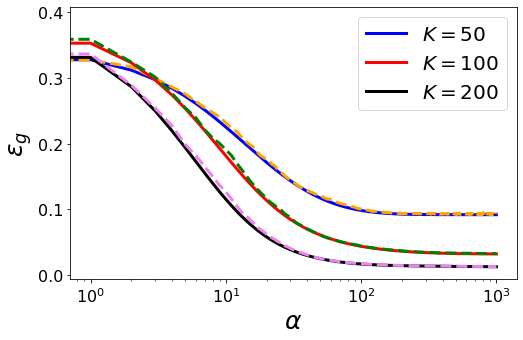

In [347]:
#compare simulation results with solution of ODEs


plt.figure(figsize=(8,5))
plt.xlabel(r"$\alpha$",size=25)
plt.ylabel(r"$\epsilon_g$",size=25)
#plt.semilogx(multi_err33[0][0][:],linewidth=3,color="black") 
#plt.semilogx(err_ode3[:],linewidth=3,linestyle="--",color="violet",label='_nolegend_') 
a=0
b=1000
#plt.yscale("log")
plt.xscale("log")

plt.plot(error50[0][0][slice(a,b)],(error50[i][1][slice(a,b)]),linewidth=3,color="b")
plt.plot(ti2[slice(a,b)],multi_errK50[0][0][slice(a,b)],linewidth=3,linestyle="--",color="orange",label='_nolegend_')

plt.plot(error100[0][0][slice(a,b)],(error100[i][1][slice(a,b)]),linewidth=3,color="red")
plt.plot(ti2[slice(a,b)],multi_errK100[0][0][slice(a,b)],linewidth=3,linestyle="--",color="green",label='_nolegend_')


plt.plot(error200[0][0][slice(a,b)],(error200[i][1][slice(a,b)]),linewidth=3,color="black")
plt.plot(ti2[slice(a,b)],multi_errK200[0][0][slice(a,b)],linewidth=3,linestyle="--",color="violet",label='_nolegend_')




plt.xticks(fontsize=16)
plt.yticks([0,0.1,0.2,0.3,0.4],fontsize=16)

plt.legend([r"$K=100$",r"$K=200$",r"$K=500$"],fontsize=20)
plt.savefig("odes_vs_simulation_N100_differentN.pdf",bbox_inches="tight")
plt.show();


In [351]:
# save to csv
df={"num": np.array([error50[i][1],error100[i][1],error200[i][1]]),
   "sim": np.array([multi_errK50[0][0],multi_errK100[0][0],multi_errK200[0][0]]),
   "K": np.array([50,100,200])}

In [352]:
dfnum=pd.DataFrame(df["num"])
dfsim=pd.DataFrame(df["sim"])
dfK=pd.DataFrame(df["K"])

In [353]:
#dfnum.to_csv("ode_vs_sim_num.csv",sep=";",header=None)
#dfsim.to_csv("ode_vs_sim_sim.csv",sep=";",header=None)
#dfK.to_csv("ode_vs_sim_K.csv",sep=";",header=None)